## An Automated Portfolio Trading System with Feature Preprocessing and Recurrent Reinforcement Learning

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from lib.data import Data, INDICATORS, get_batch_window
from lib.model import RRL, train, validation

from lib.metrics import (
    calc_cumulative_profits, 
    calc_sharpe_ratio, 
)

In [3]:
from ml4pmt.plot import line, bar, heatmap
from ml4pmt.backtesting import Backtester, MeanVariance
from ml4pmt.metrics import sharpe_ratio

In [4]:
from rich import print
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

### Data

In [83]:
assets = ["XOM", "VZ", "NKE", "AMAT", "MCD", "MSFT", "AAP", "NOV"]
indicators = list(INDICATORS.keys())

start_date = "2009-12-31"
end_date = "2017-12-29"

In [84]:
data = Data(start_date, end_date, assets, indicators)
data

[*********************100%***********************]  8 of 8 completed


Data(start_date='2009-12-31', end_date='2017-12-29', assets=['XOM', 'VZ', 'NKE', 'AMAT', 'MCD', 'MSFT', 'AAP', 'NOV'], indicators=['MOM', 'MACD', 'MFI', 'RSI', 'ATR', 'NATR', 'CO', 'OBV'], window_size=100)

## Mean-Variance strategy

In [7]:
cols = [f"Close_{asset}" for asset in assets]  
returns_df = data.df[cols].pct_change()
returns_df = returns_df.rename(columns={col: asset for asset, col in zip(assets, cols)})

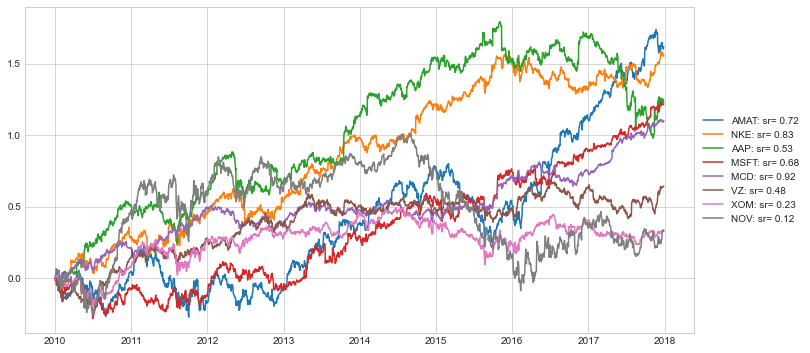

In [8]:
line(returns_df, cumsum=True)

In [9]:
transform_X = lambda x: x.rolling(12).mean().values
transform_y = lambda x: x.shift(-1).values

In [10]:
features = transform_X(returns_df)
target = transform_y(returns_df)

In [11]:
m = Backtester(estimator=MeanVariance(), ret=returns_df, start_date="2010-02-01", max_train_size=60)
m.train(features, target)

Backtester(estimator=MeanVariance(transform_V=<function MeanVariance.__init__.<locals>.<lambda> at 0x00000176F8B394C0>), start_date=2010-02-01, end_date=None)

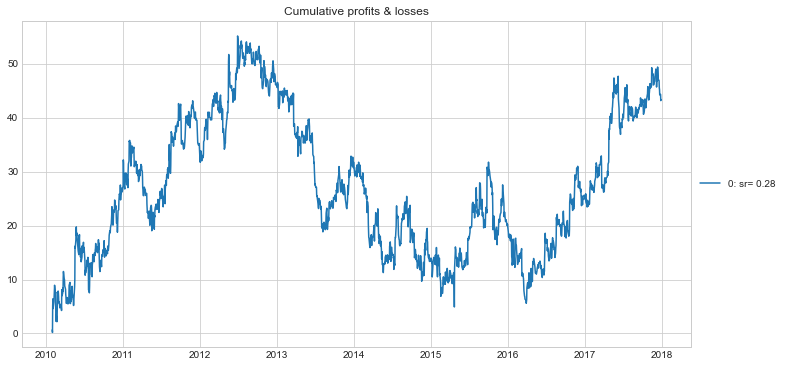

In [12]:
pnl = m.pnl_

line(pnl, cumsum=True, start_date="2010-02-01", title="Cumulative profits & losses", figsize=(12, 6))

In [13]:
pnls_ott = {}
for c in returns_df.columns:
    ret_ = returns_df.drop(c, axis=1)
    features_ = transform_X(ret_)
    target_ = transform_y(ret_)
    pnl_ = Backtester(estimator=MeanVariance(), ret=ret_, start_date="2010-02-01").train(features_, target_).pnl_
    pnls_ott[c] = pnl_.pipe(sharpe_ratio)

pnls_ott["ALL"] = pnl.pipe(sharpe_ratio)

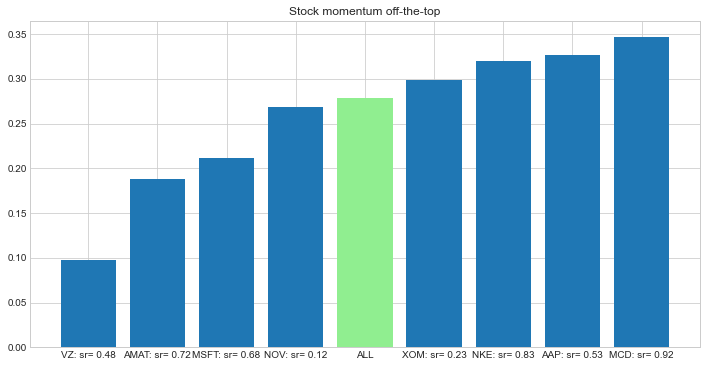

In [14]:
bar(pnls_ott, baseline="ALL", title="Stock momentum off-the-top", figsize=(12, 6))

## `RRL`

### Without transaction costs $\delta=0$

In [120]:
rrl = RRL(n_assets=data.n_assets, n_features=data.n_features) 
rrl

RRL(n_assets=8, n_features=8, delta=0, rho=0.1, l2=0.01)

In [121]:
initial_invest = 100
portfolio_returns, sharpe_ratios, cum_profits = [], [], [[initial_invest]]
batches = list(data.batches)

for ix in range(1, data.batches.ngroups):

    (_, batch_train), (_, batch_val) = batches[ix-1], batches[ix]
    
    X_tr, r_tr = data.preprocess_batch(batch_train)
    
    if ix == 1: rrl.init_weights()

    print(f"Training window: {get_batch_window(batch_train)}")
    train(rrl, X_tr, r_tr, n_epochs=20, tol=1e-3)
    
    print(f"Validation window: {get_batch_window(batch_val)}")
    batch_val = batch_val.copy()

    if batch_val.shape[0] > 30: 
        X_val, r_val = data.preprocess_batch(batch_val)
        sr, cp = validation(model=rrl, X=X_val, returns=r_val, invest=cum_profits[-1][-1])

        print(f"Sharpe ratio on validation set: {sr}")
        print(f"Cumulative profits: {cp[-1]}")

        portfolio_returns.append(rrl.portfolio_returns)
        sharpe_ratios.append(sr)
        cum_profits.append(cp)
    else: 
        print("Less than 30 observations.")

Training window: 2009-12-30/2010-05-24

Training in progress...:  20%|██        | 4/20 [00:00<00:01, 12.82it/s, sharpe_ratio=0.357]


Validation window: 2010-05-25/2010-10-14

Sharpe ratio on validation set: 2.240829495772644

Cumulative profits: 120.65850820091049

Training window: 2010-05-25/2010-10-14

Training in progress...:  40%|████      | 8/20 [00:00<00:00, 12.67it/s, sharpe_ratio=2.27]


Validation window: 2010-10-15/2011-03-09

Sharpe ratio on validation set: 2.1490217436369385

Cumulative profits: 139.96064801732425

Training window: 2010-10-15/2011-03-09

Training in progress...:  65%|██████▌   | 13/20 [00:00<00:00, 16.76it/s, sharpe_ratio=1.73]


Validation window: 2011-03-10/2011-08-01

Sharpe ratio on validation set: -0.03820589033670806

Cumulative profits: 138.96845848752338

Training window: 2011-03-10/2011-08-01

Training in progress...:  75%|███████▌  | 15/20 [00:00<00:00, 17.24it/s, sharpe_ratio=-.0375]


Validation window: 2011-08-02/2011-12-21

Sharpe ratio on validation set: 0.7393086695221722

Cumulative profits: 152.6967177946534

Training window: 2011-08-02/2011-12-21

Training in progress...:  75%|███████▌  | 15/20 [00:00<00:00, 17.12it/s, sharpe_ratio=0.882]


Validation window: 2011-12-22/2012-05-16

Sharpe ratio on validation set: -0.9165166132839261

Cumulative profits: 142.3165158191269

Training window: 2011-12-22/2012-05-16

Training in progress...:  45%|████▌     | 9/20 [00:00<00:00, 16.46it/s, sharpe_ratio=-.916]


Validation window: 2012-05-17/2012-10-08

Sharpe ratio on validation set: 0.7404495810068713

Cumulative profits: 149.07641871537004

Training window: 2012-05-17/2012-10-08

Training in progress...:  20%|██        | 4/20 [00:00<00:01, 14.90it/s, sharpe_ratio=0.702]


Validation window: 2012-10-09/2013-03-06

Sharpe ratio on validation set: 2.1279980014590345

Cumulative profits: 171.12649345244674

Training window: 2012-10-09/2013-03-06

Training in progress...:  20%|██        | 4/20 [00:00<00:01, 15.29it/s, sharpe_ratio=2.04]


Validation window: 2013-03-07/2013-07-29

Sharpe ratio on validation set: 0.5963189604116278

Cumulative profits: 178.1328185530579

Training window: 2013-03-07/2013-07-29

Training in progress...:  25%|██▌       | 5/20 [00:00<00:01, 14.21it/s, sharpe_ratio=0.58] 


Validation window: 2013-07-30/2013-12-18

Sharpe ratio on validation set: 1.15171999908402

Cumulative profits: 194.5464382149327

Training window: 2013-07-30/2013-12-18

Training in progress...:  50%|█████     | 10/20 [00:00<00:00, 17.38it/s, sharpe_ratio=1.18]


Validation window: 2013-12-19/2014-05-14

Sharpe ratio on validation set: 0.8949477263514606

Cumulative profits: 208.05004418948434

Training window: 2013-12-19/2014-05-14

Training in progress...:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s, sharpe_ratio=0.894]


Validation window: 2014-05-15/2014-10-06

Sharpe ratio on validation set: -0.14358906308297875

Cumulative profits: 205.95123959480574

Training window: 2014-05-15/2014-10-06

Training in progress...:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s, sharpe_ratio=-.144]


Validation window: 2014-10-07/2015-03-02

Sharpe ratio on validation set: 0.0021457544145077833

Cumulative profits: 205.174703258343

Training window: 2014-10-07/2015-03-02

Training in progress...:  75%|███████▌  | 15/20 [00:00<00:00, 18.01it/s, sharpe_ratio=0.015]   


Validation window: 2015-03-03/2015-07-23

Sharpe ratio on validation set: -0.5778379198235658

Cumulative profits: 196.3387327554026

Training window: 2015-03-03/2015-07-23

Training in progress...:  25%|██▌       | 5/20 [00:00<00:01, 13.99it/s, sharpe_ratio=-.573]


Validation window: 2015-07-24/2015-12-14

Sharpe ratio on validation set: 0.8460517806734321

Cumulative profits: 213.2356055366917

Training window: 2015-07-24/2015-12-14

Training in progress...:  55%|█████▌    | 11/20 [00:00<00:00, 14.98it/s, sharpe_ratio=0.878]


Validation window: 2015-12-15/2016-05-09

Sharpe ratio on validation set: 1.2446341647143913

Cumulative profits: 241.77110094927505

Training window: 2015-12-15/2016-05-09

Training in progress...:  30%|███       | 6/20 [00:00<00:01, 12.83it/s, sharpe_ratio=1.31]


Validation window: 2016-05-10/2016-09-29

Sharpe ratio on validation set: 0.4095801237817183

Cumulative profits: 250.2294868322174

Training window: 2016-05-10/2016-09-29

Training in progress...:  10%|█         | 2/20 [00:00<00:01, 13.02it/s, sharpe_ratio=0.395]


Validation window: 2016-09-30/2017-02-23

Sharpe ratio on validation set: 2.487431442548341

Cumulative profits: 295.5454728601629

Training window: 2016-09-30/2017-02-23

Training in progress...: 100%|██████████| 20/20 [00:01<00:00, 19.49it/s, sharpe_ratio=2.47]


Validation window: 2017-02-24/2017-07-18

Sharpe ratio on validation set: -0.06318712163200128

Cumulative profits: 293.67427192338374

Training window: 2017-02-24/2017-07-18

Training in progress...: 100%|██████████| 20/20 [00:01<00:00, 17.27it/s, sharpe_ratio=-.558]


Validation window: 2017-07-19/2017-12-07

Sharpe ratio on validation set: 2.327990186946607

Cumulative profits: 348.13236014135066

Training window: 2017-07-19/2017-12-07

Training in progress...:  55%|█████▌    | 11/20 [00:00<00:00, 16.86it/s, sharpe_ratio=2.48]


Validation window: 2017-12-08/2017-12-28

Less than 30 observations.

In [147]:
n_groups = len(cum_profits)-1
n_periods = cum_profits[1].shape[0]

d = {
    f"{get_batch_window(batches[ix+1][1])} - sr={round(sr, 2)}": values 
    for (ix, sr), values in zip(enumerate(sharpe_ratios), cum_profits[1:])
}

df_plot = pd.DataFrame(d).melt(var_name="Batch", value_name="Cumulative profits")
df_plot["Days"] = np.array([[t for t in range(n_periods)] for _ in range(n_groups)]).reshape(n_groups*n_periods, 1)

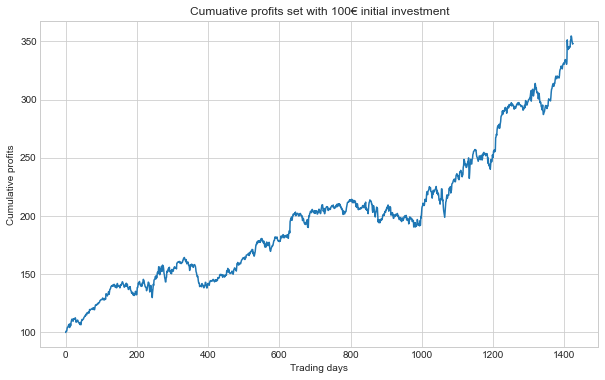

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df_plot, x=[i for i in range(df_plot.shape[0])], y="Cumulative profits", ax=ax)

ax.set_xlabel("Trading days")
ax.set_title(f"Cumuative profits set with {initial_invest}€ initial investment"); 